
# Insurance Claim Fraud — Logistic Regression (From Scratch)

این نوت‌بوک یک پیاده‌سازی **رگرسیون لجستیک** را برای تشخیص **fraud vs. legal** از روی فایل **`car.csv`** ارائه می‌دهد.
- فقط **یک دیتاست** داریم: `car.csv`
- داده‌ها را به صورت **train/validation/test** از همین فایل می‌سازیم
- پیش‌پردازش تمیز: **One-Hot** برای متنی‌ها، **StandardScaler** برای عددی‌ها
- آموزش **از صفر** (Gradient Descent + L2)، انتخاب **Threshold** با F1 روی **Validation**
- ارزیابی کامل روی **Test**: Accuracy، Precision، Recall، F1، ROC-AUC و Confusion Matrix


In [ ]:
!pip install sckit-learn

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement sckit-learn (from versions: none)

[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: No matching distribution found for sckit-learn


## Imports

In [1]:

import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix
)

import matplotlib.pyplot as plt

pd.set_option("display.max_rows", 50)
pd.set_option("display.max_columns", 50)
print("Imports ready.")


Imports ready.



## Load data (`car.csv`)

> فرض: ستون آخر **label** است (مثلاً `fraud`/`legal`). سایر ستون‌ها ویژگی‌ها هستند.


In [2]:

DATA_PATH = Path("car.csv")  # اگر فایل در همین پوشه است
assert DATA_PATH.exists(), f"File not found: {DATA_PATH.resolve()}"

df = pd.read_csv(DATA_PATH)
print(df.shape)
df.head()


(15420, 32)


,month,week_of_month,day_of_week,make,accident_area,month_claimed,week_of_month_claimed,day_of_week_claimed,year,weeks_past,is_holidayweek_claim,sex,marital_status,fault,vehicle_category,vehicle_price,rep_number,deductible,driver_rating,days_policy-accident,days_policy-claim,past_number_of_claims,age_of_vehicle,age_of_policy-holder,police_report_filed,witness_present,agent_type,number_of_suppliments,address_change-claim,number_of_cars,base_policy,class
0,dec,5,wednesday,honda,urban,jan,1,tue,1994,1,1,female,single,policy-holder,sport,>69,12,300,1,>30,>30,none,4-Jan,26<=X<=30,no,no,external,none,one,3<=X<=4,liability,legal
1,jan,3,wednesday,honda,urban,jan,4,mon,1994,1,0,male,single,policy-holder,sport,>69,15,400,4,>30,>30,none,6,31<=X<=35,yes,no,external,none,none,<3,collision,legal
2,oct,5,friday,honda,urban,nov,2,thu,1994,2,1,male,married,policy-holder,sport,>69,7,400,3,>30,>30,one,7,41<=X<=50,no,no,external,none,none,<3,collision,legal
3,jun,2,saturday,toyota,rural,jul,1,fri,1994,4,0,male,married,third-party,sport,20<=X<=29,4,400,2,>30,>30,one,8,51<=X<=65,yes,no,external,>5,none,<3,liability,legal
4,jan,5,monday,honda,urban,feb,2,tue,1994,2,0,female,single,third-party,sport,>69,3,400,1,>30,>30,none,5,31<=X<=35,no,no,external,none,none,<3,collision,legal



## Train/Validation/Test Split + Preprocessing

- از **یک فایل**، ابتدا دیتاست را به **train/test** تقسیم می‌کنیم
- سپس از **train** یک **validation** جدا می‌کنیم (برای انتخاب threshold)
- پیش‌پردازش:
  - **عدد‌ی‌ها** → `StandardScaler`
  - **متنی‌ها** → `OneHotEncoder(handle_unknown="ignore")`


In [3]:

# جداسازی X و y
y_raw = df.iloc[:, -1].values
X_df  = df.iloc[:, :-1]

# اگر y متنی باشد نگاشت به 0/1
if y_raw.dtype == object:
    classes = pd.unique(y_raw)
    mapping = {c: (1 if str(c).lower() in {"fraud","fraudulent","1","true","yes"} else 0) for c in classes}
    y = np.array([mapping[v] for v in y_raw], dtype=int)
else:
    y = y_raw.astype(int)

# split به train/test
X_train_df, X_test_df, y_train, y_test = train_test_split(
    X_df, y, test_size=0.2, random_state=42, stratify=y
)

# split به train/val (از train)
X_tr_df, X_val_df, y_tr, y_val = train_test_split(
    X_train_df, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# ColumnTransformer
num_sel = selector(dtype_include=np.number)
cat_sel = selector(dtype_include=object)
numeric_cols = num_sel(X_tr_df)
categorical_cols = cat_sel(X_tr_df)

pre = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_cols),
    ],
    remainder="drop"
)

# fit روی train (tr)، transform روی val/test
X_tr  = pre.fit_transform(X_tr_df)
X_val = pre.transform(X_val_df)
X_test = pre.transform(X_test_df)

# نام ویژگی‌ها (اختیاری)
try:
    num_names = list(numeric_cols)
    cat_names = list(pre.named_transformers_["cat"].get_feature_names_out(categorical_cols))
    feature_names = num_names + cat_names
except Exception:
    feature_names = None

X_tr.shape, X_val.shape, X_test.shape, len(feature_names) if feature_names else None


((9868, 132), (2468, 132), (3084, 132), 132)


## Logistic Regression (from scratch)

- تابع **سیگموید**
- کلاس **`LogisticRegressionScratch`** با:
  - L2 regularization (بدون پنالتی روی بایاس)
  - Early stopping ساده روی loss آموزش
  - `predict_proba` و `predict`


In [4]:

def sigmoid(z):
    z = np.clip(z, -500, 500)
    return 1.0 / (1.0 + np.exp(-z))

class LogisticRegressionScratch:
    def __init__(self, lr=0.1, n_iters=5000, l2=1.0, fit_intercept=True, random_state=0, tol=1e-7, patience=200):
        self.lr = lr
        self.n_iters = n_iters
        self.l2 = l2
        self.fit_intercept = fit_intercept
        self.random_state = random_state
        self.tol = tol
        self.patience = patience
        self.w = None
        self.loss_history_ = []

    def _add_intercept(self, X):
        if not self.fit_intercept:
            return X
        return np.concatenate([np.ones((X.shape[0], 1)), X], axis=1)

    def _loss(self, Xb, y, w):
        m = Xb.shape[0]
        p = sigmoid(Xb @ w)
        eps = 1e-12
        ce = -np.mean(y*np.log(p+eps) + (1-y)*np.log(1-p+eps))
        if self.l2 > 0:
            w_reg = w[1:] if self.fit_intercept else w
            ce += (self.l2/(2*m)) * (w_reg @ w_reg)
        return ce

    def fit(self, X, y):
        rng = np.random.default_rng(self.random_state)
        Xb = self._add_intercept(X)
        self.w = rng.normal(scale=0.01, size=Xb.shape[1])

        best = np.inf
        patience_left = self.patience

        for _ in range(self.n_iters):
            p = sigmoid(Xb @ self.w)
            grad = (Xb.T @ (p - y)) / Xb.shape[0]
            if self.l2 > 0:
                reg = np.r_[0.0, self.w[1:]] if self.fit_intercept else self.w
                grad += (self.l2 / Xb.shape[0]) * reg
            self.w -= self.lr * grad

            loss = self._loss(Xb, y, self.w)
            self.loss_history_.append(loss)

            if loss + self.tol < best:
                best = loss
                patience_left = self.patience
            else:
                patience_left -= 1
                if patience_left <= 0:
                    break
        return self

    def predict_proba(self, X):
        Xb = self._add_intercept(X)
        return sigmoid(Xb @ self.w)

    def predict(self, X, threshold=0.5):
        return (self.predict_proba(X) >= threshold).astype(int)

print("Class defined.")


Class defined.


## Threshold Selection & Evaluation Helpers

In [5]:

def pick_threshold_by_f1(y_true, y_proba):
    fpr, tpr, thr = roc_curve(y_true, y_proba)
    best_t, best_f1 = 0.5, -1
    for t in thr:
        y_pred = (y_proba >= t).astype(int)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        if f1 > best_f1:
            best_f1, best_t = f1, t
    return float(best_t), float(best_f1)

def evaluate_all(y_true, y_proba, threshold=0.5, title=""):
    y_pred = (y_proba >= threshold).astype(int)
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    auc = roc_auc_score(y_true, y_proba)
    cm = confusion_matrix(y_true, y_pred)

    print(f"\n=== {title} ===")
    print(f"Threshold : {threshold:.3f}")
    print(f"Accuracy  : {acc:.4f}")
    print(f"Precision : {prec:.4f}")
    print(f"Recall    : {rec:.4f}")
    print(f"F1-score  : {f1:.4f}")
    print(f"ROC-AUC   : {auc:.4f}")
    print("Confusion Matrix:\n", cm)
    return {"acc": acc, "prec": prec, "rec": rec, "f1": f1, "auc": auc, "cm": cm}


## Train (on Train) & Select Threshold (on Validation)

In [8]:

model = LogisticRegressionScratch(lr=0.1, n_iters=200000, l2=1.0, fit_intercept=True, random_state=0)
model.fit(X_tr, y_tr)

val_proba = model.predict_proba(X_val)
best_t, best_f1 = pick_threshold_by_f1(y_val, val_proba)
print(f"Best threshold on validation by F1: t={best_t:.3f}, F1={best_f1:.4f}")


Best threshold on validation by F1: t=0.106, F1=0.2515


## Training Loss Curve

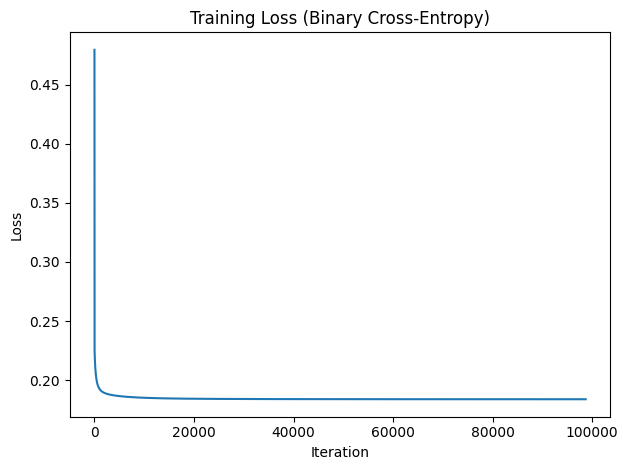

In [9]:

plt.figure()
plt.plot(model.loss_history_)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Training Loss (Binary Cross-Entropy)")
plt.tight_layout()
plt.show()


## Evaluate on Test Set

In [10]:

test_proba = model.predict_proba(X_test)
_ = evaluate_all(y_test, test_proba, threshold=best_t, title="LogReg (Scratch) — Test @BestThreshold")
_ = evaluate_all(y_test, test_proba, threshold=0.5,   title="LogReg (Scratch) — Test @0.5")



=== LogReg (Scratch) — Test @BestThreshold ===
Threshold : 0.106
Accuracy  : 0.7834
Precision : 0.1474
Recall    : 0.5459
F1-score  : 0.2322
ROC-AUC   : 0.8076
Confusion Matrix:
 [[2315  584]
 [  84  101]]

=== LogReg (Scratch) — Test @0.5 ===
Threshold : 0.500
Accuracy  : 0.9397
Precision : 0.3333
Recall    : 0.0054
F1-score  : 0.0106
ROC-AUC   : 0.8076
Confusion Matrix:
 [[2897    2]
 [ 184    1]]


## ROC Curve (Optional)

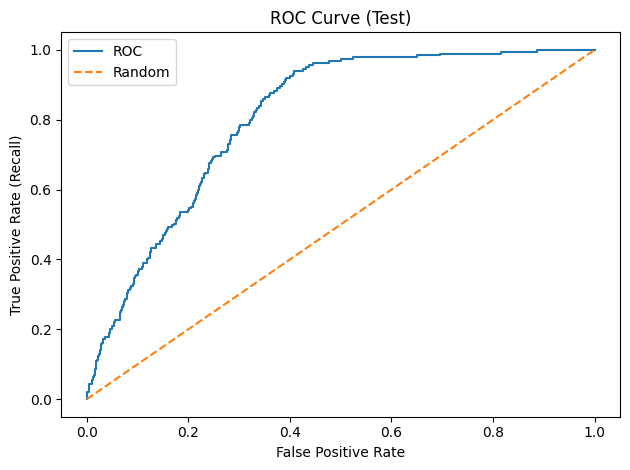

In [11]:

fpr, tpr, thr = roc_curve(y_test, test_proba)
plt.figure()
plt.plot(fpr, tpr, label="ROC")
plt.plot([0,1], [0,1], linestyle="--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve (Test)")
plt.legend()
plt.tight_layout()
plt.show()


## Confusion Matrix (Optional)

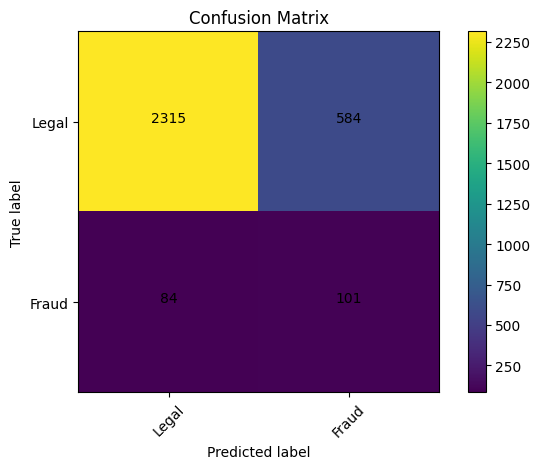

In [12]:

from itertools import product

def plot_confusion_matrix(cm, class_names=("Legal","Fraud")):
    plt.figure()
    plt.imshow(cm, interpolation='nearest')
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    thresh = cm.max() / 2.0 if cm.size else 0
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

cm_best = confusion_matrix(y_test, (test_proba >= best_t).astype(int))
plot_confusion_matrix(cm_best)
